# Notebook 03: Reporting and Visualization

This notebook creates a comprehensive report summarizing all metrics collected during embedding and inference operations.

## Report Contents

1. **Executive Summary**: High-level overview of the experiment
2. **Metrics Dashboard**: Detailed tables with token and timing statistics
3. **Visualizations**: Charts showing distributions, relationships, and comparisons
4. **Interpretation**: Analysis of what the metrics mean and practical implications

## Setup


In [1]:
# Import standard library modules
import sys
from pathlib import Path

# Add the src directory to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import our custom modules
from src.config import Config
from src.reporting import (
    load_metrics,
    aggregate_metrics,
    create_summary_tables,
    plot_token_distribution,
    plot_latency_vs_tokens,
    plot_throughput_comparison,
    plot_latency_distribution
)

# Import visualization libraries
import matplotlib.pyplot as plt
import pandas as pd

# Set up matplotlib for better-looking plots
# Try to use a nice style, fall back to default if not available
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
%matplotlib inline

print("Modules imported successfully!")


Modules imported successfully!


## Load Metrics

Load the metrics collected from notebooks 01 and 02.


In [2]:
# Create configuration to get paths
config = Config()

# Load metrics from JSON file
metrics_path = config.get_metrics_path()
print(f"Loading metrics from: {metrics_path}")

# Load into pandas DataFrame for easy analysis
df = load_metrics(metrics_path)

print(f"Loaded {len(df)} metric records")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Loading metrics from: results/metrics.json
Loaded 3855 metric records

Columns: ['call_type', 'duration_seconds', 'token_counts', 'timestamp', 'chunk_id', 'embedding_size', 'question_id', 'response_text']

First few rows:


,call_type,duration_seconds,token_counts,timestamp,chunk_id,embedding_size,question_id,response_text
0,embedding,1.636022,{'input_tokens': 511},1.763839e+09,chunk_0,768.0,NaN,NaN
1,embedding,0.429294,{'input_tokens': 511},1.763839e+09,chunk_1,768.0,NaN,NaN
2,embedding,0.413686,{'input_tokens': 507},1.763839e+09,chunk_2,768.0,NaN,NaN
3,embedding,0.331378,{'input_tokens': 490},1.763839e+09,chunk_3,768.0,NaN,NaN
4,embedding,0.399785,{'input_tokens': 467},1.763839e+09,chunk_4,768.0,NaN,NaN


## Executive Summary

High-level overview of the experiment and key findings.


### Experiment Overview

This experiment demonstrates token and timing tracking for LLM operations using:
- **Embedding Model**: Gemma embedding model via Ollama (`embeddinggemma`)
- **Generation Model**: Gemma3 1B model via Ollama (`gemma3:1b`)
- **Infrastructure**: Local Ollama instance running on `http://localhost:11434`

The workflow involved:
1. Loading and chunking a text document
2. Embedding all chunks to create vector representations
3. Generating questions and performing inference operations
4. Tracking all tokens and timing metrics throughout

### Key Objectives

- Measure token usage for embedding vs inference operations
- Track latency (time per call) for different operation types
- Calculate throughput (tokens per second)
- Understand performance characteristics of Gemma models via Ollama


## Metrics Dashboard

Aggregate all metrics and display summary statistics.


In [3]:
# Aggregate metrics to compute summary statistics
aggregated = aggregate_metrics(df)

# Create summary table
summary_table = create_summary_tables(aggregated)

print("Summary Statistics")
print("=" * 80)
# Display the table (display() works in Jupyter, print() works everywhere)
try:
    display(summary_table)  # Jupyter/IPython
except NameError:
    print(summary_table)  # Fallback for non-Jupyter environments


Summary Statistics


,Call Type,Total Calls,Total Tokens,Total Time (s),Avg Latency (s),P95 Latency (s),Tokens/sec
0,Embedding,772,372167,159.95,0.21,0.25,2326.78
1,Inference,3083,1632403,602.42,0.20,0.23,2709.72
2,Overall,3855,2004570,762.37,-,-,2629.38


### Detailed Breakdown

Let's examine the aggregated metrics in more detail:


In [4]:
# Display detailed metrics
if 'embedding' in aggregated:
    print("Embedding Metrics:")
    print("-" * 40)
    emb = aggregated['embedding']
    for key, value in emb.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2f}")
        else:
            print(f"  {key}: {value}")
    print()

if 'inference' in aggregated:
    print("Inference Metrics:")
    print("-" * 40)
    inf = aggregated['inference']
    for key, value in inf.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2f}")
        else:
            print(f"  {key}: {value}")
    print()

if 'overall' in aggregated:
    print("Overall Metrics:")
    print("-" * 40)
    ovr = aggregated['overall']
    for key, value in ovr.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2f}")
        else:
            print(f"  {key}: {value}")


Embedding Metrics:
----------------------------------------
  total_calls: 772
  total_tokens: 372167
  total_time_seconds: 159.95
  avg_tokens_per_call: 482.08
  avg_latency_seconds: 0.21
  p50_latency_seconds: 0.20
  p95_latency_seconds: 0.25
  tokens_per_second: 2326.78

Inference Metrics:
----------------------------------------
  total_calls: 3083
  total_prompt_tokens: 1585120
  total_response_tokens: 47283
  total_tokens: 1632403
  total_time_seconds: 602.42
  avg_prompt_tokens: 514.15
  avg_response_tokens: 15.34
  avg_latency_seconds: 0.20
  p50_latency_seconds: 0.19
  p95_latency_seconds: 0.23
  tokens_per_second: 2709.72

Overall Metrics:
----------------------------------------
  total_calls: 3855
  total_tokens: 2004570
  total_time_seconds: 762.37
  tokens_per_second: 2629.38


## Visualizations

Create visualizations to better understand the data distributions and relationships.


### Token Distribution (for Chunks)

This histogram shows how tokens are distributed across chunks. This helps understand if chunking is consistent or varies significantly.


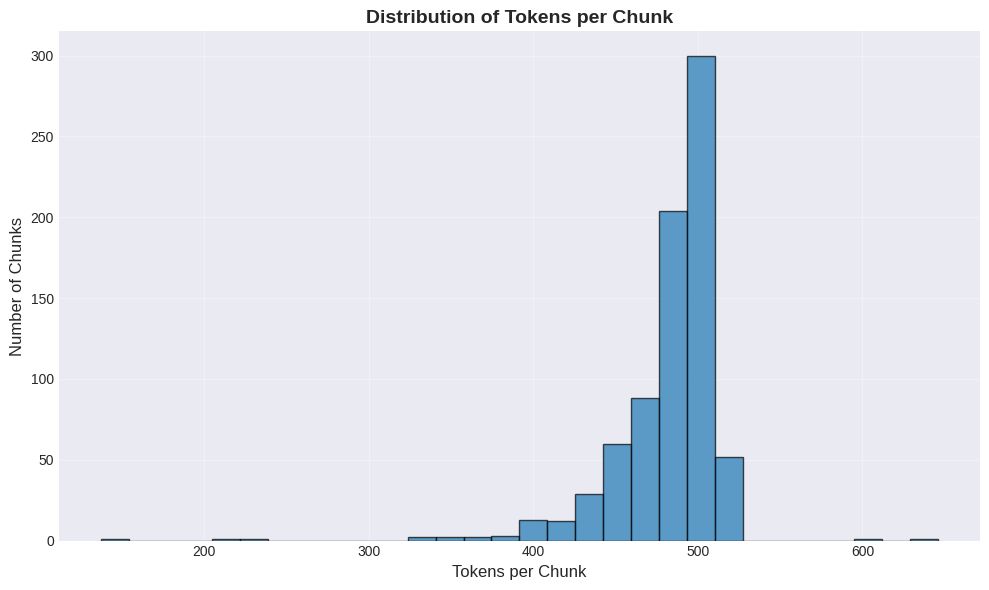

In [5]:
# Load chunks to get token distribution
import json

chunks_path = config.get_chunks_path()
if chunks_path.exists():
    with open(chunks_path, 'r') as f:
        chunks = json.load(f)
    
    # Create DataFrame from chunks
    chunks_df = pd.DataFrame(chunks)
    
    # Plot token distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_token_distribution(chunks_df, ax)
    plt.tight_layout()
    plt.show()
else:
    print("Chunks file not found. Run notebook 01 first.")


### Latency vs Token Count

This scatter plot shows the relationship between the number of tokens and the time it takes to process them. Generally, more tokens should take longer, but the relationship may not be perfectly linear.


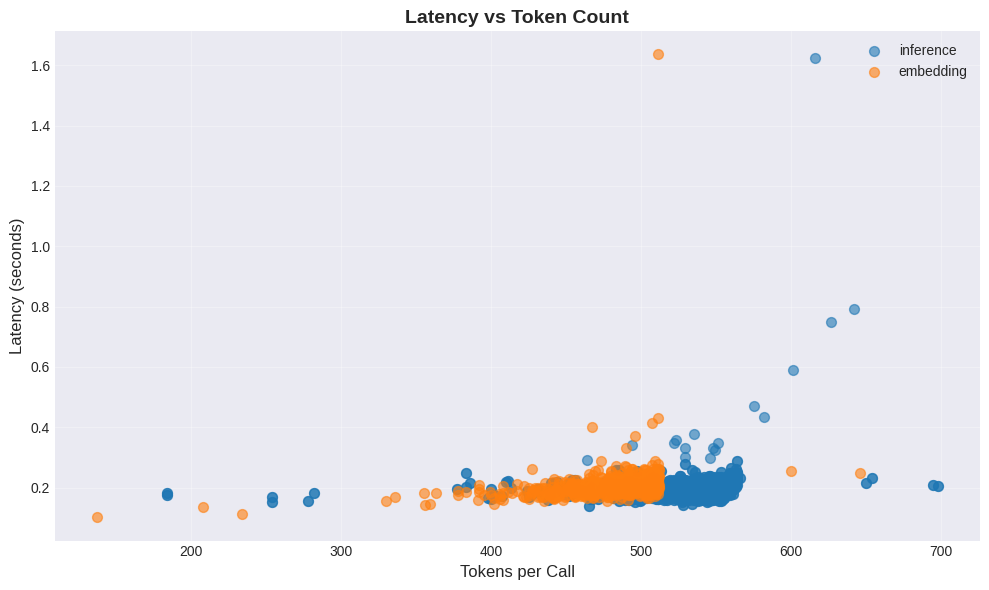

In [6]:
# Plot latency vs tokens
fig, ax = plt.subplots(figsize=(10, 6))
plot_latency_vs_tokens(df, ax)
plt.tight_layout()
plt.show()


### Throughput Comparison

This bar chart compares tokens per second (throughput) between embedding and inference operations. Higher is better - it means the system processes tokens faster.


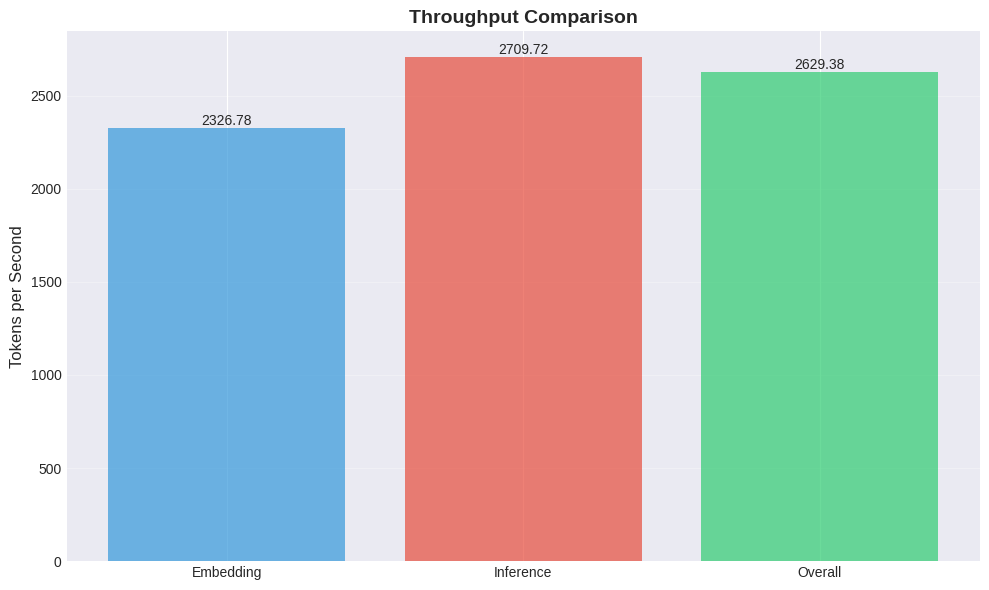

In [7]:
# Plot throughput comparison
fig, ax = plt.subplots(figsize=(10, 6))
plot_throughput_comparison(aggregated, ax)
plt.tight_layout()
plt.show()


### Latency Distribution

This histogram shows the distribution of call latencies. A narrow distribution means consistent performance, while a wide distribution indicates variability in call times.


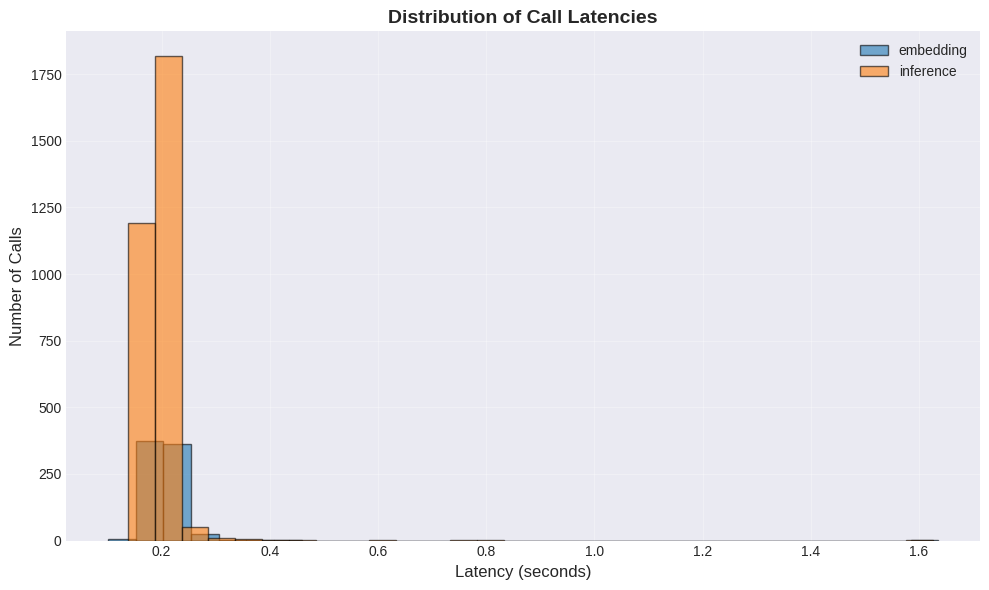

In [8]:
# Plot latency distribution
fig, ax = plt.subplots(figsize=(10, 6))
plot_latency_distribution(df, ax)
plt.tight_layout()
plt.show()


## Interpretation and Analysis

### What Do These Numbers Mean?

**Token Usage:**
- Tokens are the basic units that language models process. One token is roughly 0.75 words in English.
- Total tokens show the overall "cost" of operations in terms of processing units.
- Comparing embedding vs inference tokens helps understand where most processing happens.

**Latency:**
- Latency is the time it takes for a single operation to complete.
- Average latency gives you the typical wait time per call.
- P95 latency (95th percentile) shows the worst-case scenario for 95% of calls - useful for understanding tail performance.

**Throughput:**
- Tokens per second measures how fast the system processes tokens.
- Higher throughput means the system is more efficient.
- Comparing embedding vs inference throughput shows which operation type is faster.

### Key Insights

1. **Embedding vs Inference Cost**: 
   - Embedding operations typically process more tokens (the entire document), but may be faster per token.
   - Inference operations process fewer tokens per call but may be slower due to generation complexity.

2. **Performance Characteristics**:
   - If latency varies significantly (wide distribution), it may indicate system load or model variability.
   - Consistent latency suggests stable performance.

3. **Practical Implications**:
   - For large documents, embedding time can be significant - consider batch processing or parallelization.
   - Inference latency directly impacts user experience - optimize prompts to reduce token counts when possible.
   - Throughput metrics help estimate total processing time for large workloads.

### Recommendations

- **For Production Use**: Monitor P95 latency to ensure acceptable worst-case performance.
- **For Cost Optimization**: Track total tokens to estimate computational costs.
- **For Performance Tuning**: Use throughput metrics to identify bottlenecks and optimization opportunities.
